# In this module, you were introduced to the amazing and challenging domain of unsupervised learning; you explored some of the most popular clustering and dimensionality reduction algorithms. Now, it's time for you to apply your unsupervised learning knowledge. In this challenge, you'll work with a dataset of your choice. As always, Kaggle will be one of your best friends. Spend some time on Kaggle and pick a beautiful dataset. Then, using that dataset, do the following:

# * Apply dimensionality reduction techniques to visualize the observations.

# * Apply clustering techniques to group similar observations.

# For each of the tasks above, try several methods and select the best-performing one. Discuss how dimensionality reduction and clustering algorithms enable you to gain insights regarding the data.

In [177]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import umap

from sklearn import datasets, metrics
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings

warnings.filterwarnings('ignore')

# Aerial Bombing Operations in World War II

## * Target, aircraft used, and bombs deployed for every mission in WWII

## * https://www.kaggle.com/usaf/world-war-ii

In [2]:
ops_df = pd.read_csv('data/operations.csv')

In [3]:
ops_df.head()

Mission ID Mission Date Theater of Operations Country Air Force  \
0           1    8/15/1943                   MTO     USA     12 AF   
1           2    8/15/1943                   PTO     USA      5 AF   
2           3    8/15/1943                   MTO     USA     12 AF   
3           4    8/15/1943                   MTO     USA     12 AF   
4           5    8/15/1943                   PTO     USA      5 AF   

         Unit ID Aircraft Series Callsign Mission Type          Takeoff Base  \
0  27 FBG/86 FBG             A36      NaN          NaN  PONTE OLIVO AIRFIELD   
1         400 BS             B24      NaN            1                   NaN   
2  27 FBG/86 FBG             A36      NaN          NaN  PONTE OLIVO AIRFIELD   
3  27 FBG/86 FBG             A36      NaN          NaN  PONTE OLIVO AIRFIELD   
4         321 BS             B24      NaN            1                   NaN   

   ... Incendiary Devices Weight (Tons) Fragmentation Devices  \
0  ...                              NaN                   NaN   
1  ...                              NaN                   NaN   
2  ...                              NaN                   NaN   
3  ...                              NaN                   NaN   
4  ...                              NaN                   NaN   

   Fragmentation Devices Type Fragmentation Devices Weight (Pounds)  \
0                         NaN                                   NaN   
1                         NaN                                   NaN   
2                         NaN                                   NaN   
3                         NaN                                   NaN   
4                         NaN                                   NaN   

  Fragmentation Devices Weight (Tons) Total Weight (Pounds)  \
0                                 NaN                   NaN   
1                                 NaN                   NaN   
2                                 NaN                   NaN   
3                                 NaN                   NaN   
4                                 NaN                   NaN   

  Total Weight (Tons) Time Over Target Bomb Damage Assessment  Source ID  
0                10.0              NaN                    NaN        NaN  
1                20.0              NaN                    NaN     9366.0  
2                 9.0              NaN                    NaN        NaN  
3                 7.5              NaN                    NaN        NaN  
4                 8.0              NaN                    NaN    22585.0  

[5 rows x 46 columns]

The dataset needs some preprocessing

In [4]:
ops_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178281 entries, 0 to 178280
Data columns (total 46 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Mission ID                             178281 non-null  int64  
 1   Mission Date                           178281 non-null  object 
 2   Theater of Operations                  175123 non-null  object 
 3   Country                                126494 non-null  object 
 4   Air Force                              126444 non-null  object 
 5   Unit ID                                50913 non-null   object 
 6   Aircraft Series                        178165 non-null  object 
 7   Callsign                               21 non-null      object 
 8   Mission Type                           47186 non-null   object 
 9   Takeoff Base                           3383 non-null    object 
 10  Takeoff Location                       3338 non-null    

In [5]:
ops_df.isna().mean()

Mission ID                               0.000000
Mission Date                             0.000000
Theater of Operations                    0.017714
Country                                  0.290480
Air Force                                0.290760
Unit ID                                  0.714423
Aircraft Series                          0.000651
Callsign                                 0.999882
Mission Type                             0.735328
Takeoff Base                             0.981024
Takeoff Location                         0.981277
Takeoff Latitude                         0.983279
Takeoff Longitude                        0.983285
Target ID                                0.285364
Target Country                           0.003360
Target City                              0.012693
Target Type                              0.178993
Target Industry                          0.290564
Target Priority                          0.244339
Target Latitude                          0.048889


In [6]:
features = ['Target Country'
            ,'Target City'
            ,'Target Type'
            ,'Target Priority'
            ,'High Explosives'
           ]
target = ['Mission Date']

model_df = ops_df[features].join(ops_df[target])
model_df = model_df.dropna()

In [7]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31551 entries, 1 to 178280
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Target Country   31551 non-null  object 
 1   Target City      31551 non-null  object 
 2   Target Type      31551 non-null  object 
 3   Target Priority  31551 non-null  object 
 4   High Explosives  31551 non-null  float64
 5   Mission Date     31551 non-null  object 
dtypes: float64(1), object(5)
memory usage: 1.7+ MB


In [8]:
model_df["Target Country"] = model_df["Target Country"].astype("category").cat.codes
model_df["Target City"] = model_df["Target City"].astype("category").cat.codes
model_df["Target Type"] = model_df["Target Type"].astype("category").cat.codes
model_df["Target Priority"] = model_df["Target Priority"].astype("category").cat.codes

In [9]:
model_df['year'] = pd.DatetimeIndex(model_df['Mission Date']).strftime('%Y%m')
model_df = model_df.drop(columns=['Mission Date'])

In [10]:
model_df['year'] = model_df['year'].astype(int)

# K-means analysis

In [11]:
sample = model_df.sample(10000, random_state=66)
sample

Target Country  Target City  Target Type  Target Priority  \
96448               29         2011           41                1   
156706               2         1239           41                1   
16509                1         1644           41                1   
22995                5         3579          129                1   
30580               27         3502         1434                1   
...                ...          ...          ...              ...   
140327               2          395          467                8   
59406                2         2484           41                2   
145287              15         3064         1443                3   
93792               29         2179         1434                1   
136572              30         1327           48                1   

        High Explosives    year  
96448              26.0  194411  
156706            280.0  194501  
16509              84.0  194401  
22995              20.0  194408  
30580              16.0  194408  
...                 ...     ...  
140327              4.0  194507  
59406               8.0  194504  
145287              6.0  194507  
93792              20.0  194504  
136572              4.0  194406  

[10000 rows x 6 columns]

In [12]:
X = sample[features]
y = sample['year']

In [13]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [14]:
for k in range(2, 5):
    k_means = KMeans(n_clusters=k, random_state=66)
    k_means.fit(X_std)
    y_pred = k_means.predict(X_std)
    print("Adjusted Rand Index: {}".format(metrics.adjusted_rand_score(y, y_pred)))
    print("The silhoutte score: {}".format(metrics.silhouette_score(X, y_pred, metric='euclidean')))

Adjusted Rand Index: 0.0035589558329631094
The silhoutte score: 0.02766474320683576
Adjusted Rand Index: 0.00808601745673085
The silhoutte score: -0.021451493022792995
Adjusted Rand Index: 0.00810092355730975
The silhoutte score: -0.02123729792317286


# Heriarchical

In [15]:
sample = model_df.sample(500, random_state=66)
sample

Target Country  Target City  Target Type  Target Priority  \
96448               29         2011           41                1   
156706               2         1239           41                1   
16509                1         1644           41                1   
22995                5         3579          129                1   
30580               27         3502         1434                1   
...                ...          ...          ...              ...   
12509                5         1623           41                1   
94791               27         1328          905                1   
133266              29         2552          359                8   
79477               29          181         1174                1   
82865                5         1278           41                1   

        High Explosives    year  
96448              26.0  194411  
156706            280.0  194501  
16509              84.0  194401  
22995              20.0  194408  
30580              16.0  194408  
...                 ...     ...  
12509              28.0  194408  
94791              20.0  194411  
133266             32.0  194506  
79477               6.0  194410  
82865               8.0  194410  

[500 rows x 6 columns]

In [16]:
X = sample[features]
y = sample['year']

In [17]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

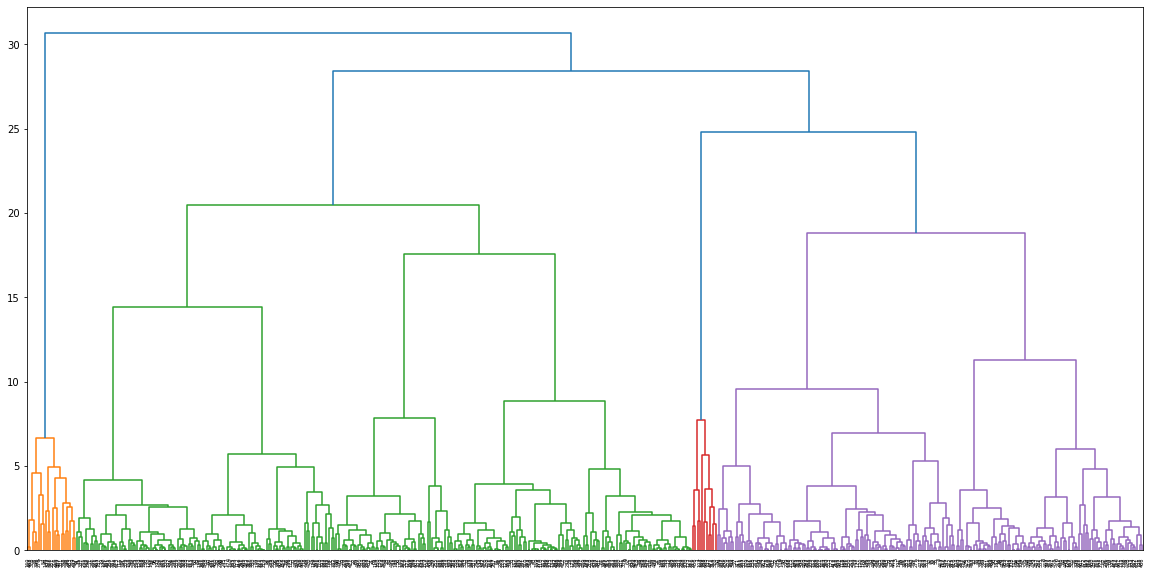

In [18]:
plt.figure(figsize=(20,10))
dendrogram(linkage(X_std, method='ward'))
plt.show()

# DBSCAN

In [19]:
sample = model_df.sample(10000, random_state=66)
sample

Target Country  Target City  Target Type  Target Priority  \
96448               29         2011           41                1   
156706               2         1239           41                1   
16509                1         1644           41                1   
22995                5         3579          129                1   
30580               27         3502         1434                1   
...                ...          ...          ...              ...   
140327               2          395          467                8   
59406                2         2484           41                2   
145287              15         3064         1443                3   
93792               29         2179         1434                1   
136572              30         1327           48                1   

        High Explosives    year  
96448              26.0  194411  
156706            280.0  194501  
16509              84.0  194401  
22995              20.0  194408  
30580              16.0  194408  
...                 ...     ...  
140327              4.0  194507  
59406               8.0  194504  
145287              6.0  194507  
93792              20.0  194504  
136572              4.0  194406  

[10000 rows x 6 columns]

In [20]:
X = sample[features]
y = sample['year']

In [21]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [22]:
for i in range(1, 4):
    dbscan_cluster = DBSCAN(eps=1, min_samples=i, metric='euclidean')
    clusters = dbscan_cluster.fit_predict(X_std)
    print(metrics.silhouette_score(X, clusters))
    print(metrics.adjusted_rand_score(y, clusters))

-0.6096134581939153
0.003546873011812884
-0.4369871449620984
0.003547384068727451
-0.1421433564749225
0.003548093548913898


# Gaussian (GMM)

In [23]:
sample = model_df.sample(10000, random_state=66)
sample

Target Country  Target City  Target Type  Target Priority  \
96448               29         2011           41                1   
156706               2         1239           41                1   
16509                1         1644           41                1   
22995                5         3579          129                1   
30580               27         3502         1434                1   
...                ...          ...          ...              ...   
140327               2          395          467                8   
59406                2         2484           41                2   
145287              15         3064         1443                3   
93792               29         2179         1434                1   
136572              30         1327           48                1   

        High Explosives    year  
96448              26.0  194411  
156706            280.0  194501  
16509              84.0  194401  
22995              20.0  194408  
30580              16.0  194408  
...                 ...     ...  
140327              4.0  194507  
59406               8.0  194504  
145287              6.0  194507  
93792              20.0  194504  
136572              4.0  194406  

[10000 rows x 6 columns]

In [24]:
X = sample[features]
y = sample['year']

In [25]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [26]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=2, random_state=66)

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

In [27]:
print("The silhoutte score of the GMM solution: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))
print("Adjusted Rand Index of the GMM solution: {}"
      .format(metrics.adjusted_rand_score(y, clusters)))

The silhoutte score of the GMM solution: 0.23366190011435983
Adjusted Rand Index of the GMM solution: 0.0063193764522673675


In [28]:
types = ['full', 'tied', 'diag', 'spherical']
sils = []
aris = []

In [29]:
for typ in types:
    gmm_cluster = GaussianMixture(n_components=2, covariance_type=typ, random_state=66)

    # Fit model
    clusters = gmm_cluster.fit_predict(X_std)
    aris.append([metrics.adjusted_rand_score(y, clusters), typ])
    sils.append([metrics.silhouette_score(X_std, clusters, metric='euclidean'), typ])

In [30]:
sils.sort(reverse=True)
aris.sort(reverse=True)

In [31]:
print('Best silhouette score: ' + str(sils[0]))
print('Best ARI score: ' + str(aris[0]))

Best silhouette score: [0.2731873864991124, 'tied']
Best ARI score: [0.006363889195806141, 'diag']


# PCA

In [131]:
sample = model_df.sample(5000, random_state=66)
sample

Target Country  Target City  Target Type  Target Priority  \
96448               29         2011           41                1   
156706               2         1239           41                1   
16509                1         1644           41                1   
22995                5         3579          129                1   
30580               27         3502         1434                1   
...                ...          ...          ...              ...   
26887                1          627         1308                1   
76101                6          383         1434                1   
14293               10         1353           41                1   
97406                3         2884          361                1   
124556              29         2960         1400                1   

        High Explosives    year  
96448              26.0  194411  
156706            280.0  194501  
16509              84.0  194401  
22995              20.0  194408  
30580              16.0  194408  
...                 ...     ...  
26887              72.0  194310  
76101              16.0  194404  
14293              16.0  194503  
97406              12.0  194405  
124556            100.0  194505  

[5000 rows x 6 columns]

In [145]:
X = sample[features]

y = (sample["year"].astype("category").cat.codes / 4).astype(int)
y = y.tolist()

In [147]:
pca = PCA(n_components=2)

pca_X = pca.fit_transform(X_std)

In [148]:
pca_X

array([[ 0.61439834,  0.9574932 ],
       [ 0.27821639,  2.14666801],
       [-0.50446462,  1.22958607],
       ...,
       [-0.18251886, -0.65601709],
       [ 0.30057601, -0.60374651],
       [ 0.91431028,  0.62131238]])

IndexError: list index out of range

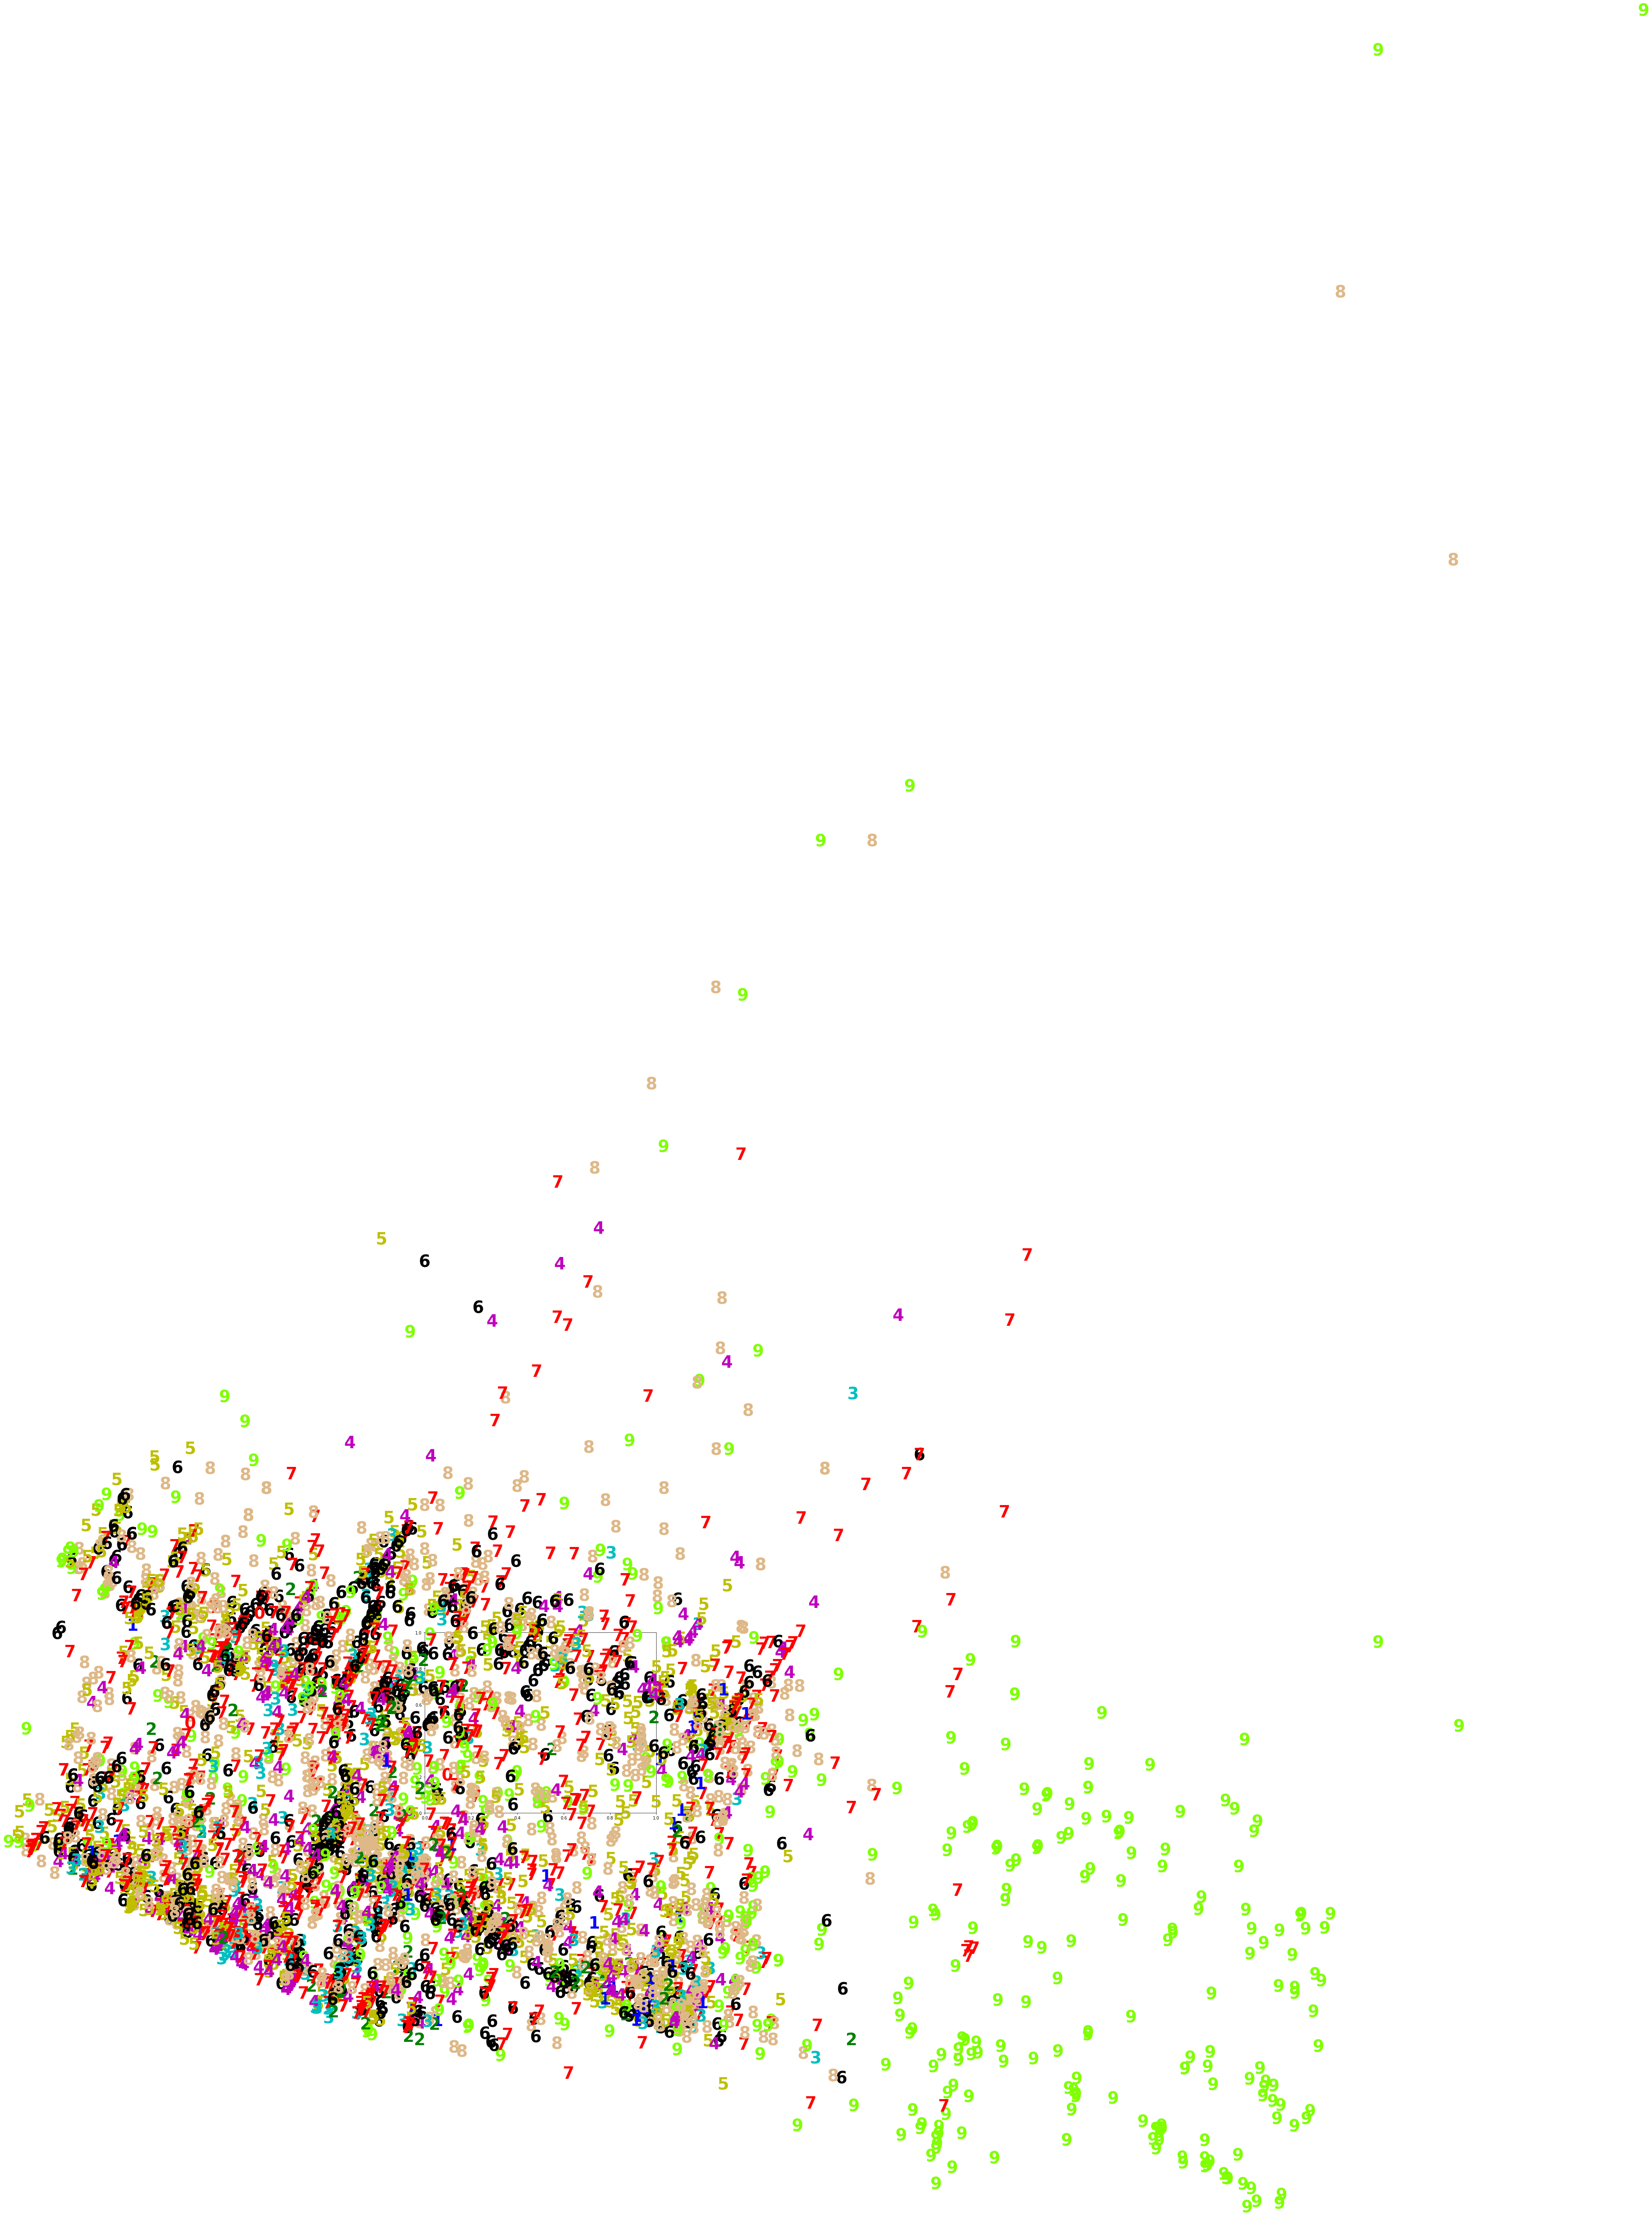

In [157]:
plt.figure(figsize=(10,8))
colours = ["r","b","g","c","m","y","k","r","burlywood","chartreuse"]
for i in range(len(pca_X)):
    plt.text(pca_X[i, 0], pca_X[i, 1], str(y[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 40}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

# t-SNE

In [167]:
sample = model_df.sample(2000, random_state=66)
sample

Target Country  Target City  Target Type  Target Priority  \
96448               29         2011           41                1   
156706               2         1239           41                1   
16509                1         1644           41                1   
22995                5         3579          129                1   
30580               27         3502         1434                1   
...                ...          ...          ...              ...   
65410               26         3303         1434                1   
166934              29          743          475                1   
59106                3         1295         1243                1   
28921                3         2310         1400                1   
64976                1         2413         1434                1   

        High Explosives    year  
96448         26.000000  194411  
156706       280.000000  194501  
16509         84.000000  194401  
22995         20.000000  194408  
30580         16.000000  194408  
...                 ...     ...  
65410         80.000000  194403  
166934        26.000000  194502  
59106        120.000000  194410  
28921          6.153846  194503  
64976          4.000000  194403  

[2000 rows x 6 columns]

In [168]:
X = sample[features]

y = (sample["year"].astype("category").cat.codes / 4).astype(int)
y = y.tolist()

In [173]:
for perp in range(100, 101):
    tsne = TSNE(n_components=2, verbose=1, perplexity=perp, n_iter=300)
    tsne_components = tsne.fit_transform(X)
    
    plt.figure(figsize=(10,5))
    colours = ["r","b","g","c","m","y","k","r","burlywood","chartreuse"]
    for i in range(tsne_components.shape[0]):
        plt.text(tsne_components[i, 0], tsne_components[i, 1], str(y[i]),
                 color=colours[int(y[i])],
                 fontdict={'weight': 'bold', 'size': 50}
            )

    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.title('perplexity = ' + str(perp))
    plt.show()

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.004s...
[t-SNE] Computed neighbors for 2000 samples in 0.188s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 31.358052
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.887005
[t-SNE] KL divergence after 300 iterations: 0.399024


# UMAP

In [178]:
sample = model_df.sample(5000, random_state=66)
sample

Target Country  Target City  Target Type  Target Priority  \
96448               29         2011           41                1   
156706               2         1239           41                1   
16509                1         1644           41                1   
22995                5         3579          129                1   
30580               27         3502         1434                1   
...                ...          ...          ...              ...   
26887                1          627         1308                1   
76101                6          383         1434                1   
14293               10         1353           41                1   
97406                3         2884          361                1   
124556              29         2960         1400                1   

        High Explosives    year  
96448              26.0  194411  
156706            280.0  194501  
16509              84.0  194401  
22995              20.0  194408  
30580              16.0  194408  
...                 ...     ...  
26887              72.0  194310  
76101              16.0  194404  
14293              16.0  194503  
97406              12.0  194405  
124556            100.0  194505  

[5000 rows x 6 columns]

In [179]:
X = sample[features]

y = (sample["year"].astype("category").cat.codes / 4).astype(int)
y = y.tolist()

In [182]:
umap_results = umap.UMAP(n_neighbors=20,
                          min_dist=0.3,
                          metric='correlation').fit_transform(X)

In [183]:
plt.figure(figsize=(10, 5))
colours = ["r","b","g","c","m","y","k","r","burlywood","chartreuse"]
for i in range(umap_results.shape[0]):
    plt.text(umap_results[i, 0], umap_results[i, 1], str(y[i]),
             color=colours[int(y[i])],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()